# GFSK 调制中的相位脉冲与脉冲长度

本文档通过可视化方式讲解 GFSK 调制的核心概念。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 100

## 1. 核心概念速查表

| 概念 | 符号 | 含义 | BLE 典型值 |
|------|------|------|------------|
| **符号周期** | T | 一个比特持续的时间 | 1 μs (LE 1M) |
| **频率脉冲** | g(t) | 单个比特对瞬时频率的贡献形状 | 高斯钟形曲线 |
| **相位脉冲** | q(t) | 频率脉冲的积分，描述相位累积 | S 形曲线 |
| **脉冲长度** | L | 频率脉冲跨越的符号周期数 | 1 (Full Response) |

## 2. 符号周期 T (Symbol Period)

**符号周期是一个比特（符号）持续的时间长度**。

```
符号周期 T = 1 / 符号率

BLE LE 1M: 符号率 = 1 MHz → T = 1 μs
BLE LE 2M: 符号率 = 2 MHz → T = 0.5 μs
```

In [2]:
# 符号周期与采样的关系
sample_rate = 8e6  # 8 MHz
symbol_rate_1m = 1e6  # LE 1M
symbol_rate_2m = 2e6  # LE 2M

T_1m = 1 / symbol_rate_1m  # 符号周期 (秒)
T_2m = 1 / symbol_rate_2m

sps_1m = int(sample_rate / symbol_rate_1m)  # 每符号采样数
sps_2m = int(sample_rate / symbol_rate_2m)

print(f"LE 1M: T = {T_1m*1e6:.1f} μs, 每符号 {sps_1m} 个采样点")
print(f"LE 2M: T = {T_2m*1e6:.2f} μs, 每符号 {sps_2m} 个采样点")

LE 1M: T = 1.0 μs, 每符号 8 个采样点
LE 2M: T = 0.50 μs, 每符号 4 个采样点


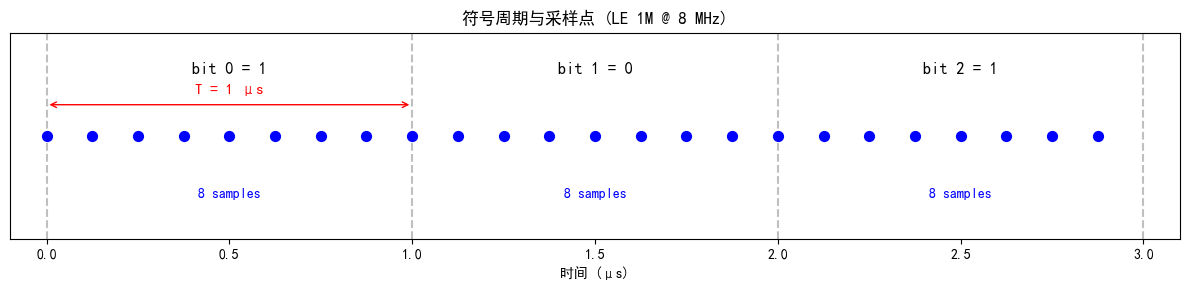

In [3]:
# 可视化符号周期与采样点
fig, ax = plt.subplots(figsize=(12, 3))

# 3 个符号的时间轴
bits = [1, 0, 1]
t_us = np.arange(0, 3 * sps_1m) / sample_rate * 1e6  # 微秒

# 绘制符号边界
for i in range(4):
    ax.axvline(i * T_1m * 1e6, color='gray', linestyle='--', alpha=0.5)

# 绘制采样点
ax.scatter(t_us, np.zeros_like(t_us), c='blue', s=50, zorder=5)

# 标注
for i, bit in enumerate(bits):
    ax.text((i + 0.5) * T_1m * 1e6, 0.3, f'bit {i} = {bit}', ha='center', fontsize=12)
    ax.text((i + 0.5) * T_1m * 1e6, -0.3, f'{sps_1m} samples', ha='center', fontsize=10, color='blue')

ax.annotate('', xy=(T_1m * 1e6, 0.15), xytext=(0, 0.15),
            arrowprops=dict(arrowstyle='<->', color='red'))
ax.text(T_1m * 1e6 / 2, 0.2, 'T = 1 μs', ha='center', color='red', fontsize=11)

ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('时间 (μs)')
ax.set_title('符号周期与采样点 (LE 1M @ 8 MHz)')
ax.set_yticks([])
plt.tight_layout()
plt.show()

## 3. 从 FSK 到 GFSK: 为什么需要高斯滤波？

### 传统 FSK 的问题

在传统 FSK 中，频率**瞬间跳变**，产生方波频率信号。方波的边缘包含无穷多高频分量，导致频谱很宽。

### GFSK 的解决方案

GFSK 使用**高斯滤波器**平滑频率变化，使频谱更窄，满足 BLE 频谱模板要求。

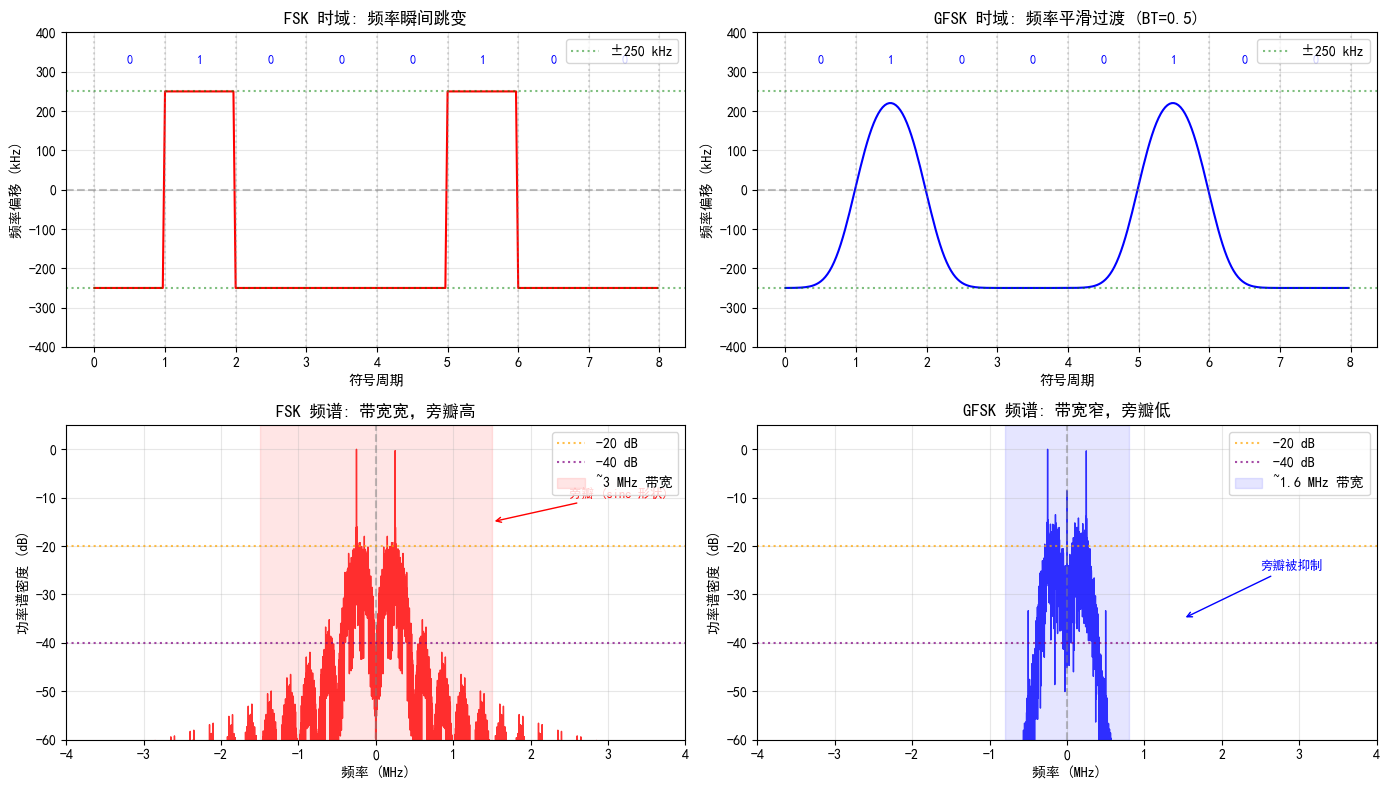

频谱分析结果:
FSK  -20dB 带宽: 0.52 MHz
GFSK -20dB 带宽: 0.56 MHz
带宽节省: -7.1%

关键区别:
- FSK:  方波跳变 → sinc 频谱 → 旁瓣高，带外辐射大
- GFSK: 高斯平滑 → 高斯频谱 → 旁瓣低，带外辐射小

BLE 规范要求:
- 邻道 (±2 MHz) 功率 < -20 dBm
- 次邻道 (±3 MHz) 功率 < -30 dBm
- GFSK (BT=0.5) 可以满足这些要求


In [4]:
# FSK vs GFSK 频率波形与频谱对比
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 模拟比特序列 (更长以获得更好的频谱分辨率)
np.random.seed(42)
bits = np.random.randint(0, 2, 256)
symbols = 2 * bits - 1  # NRZ: 0->-1, 1->+1

# 参数
sps = 32  # 每符号采样点
sample_rate = 8e6  # 8 MHz
symbol_rate = 1e6  # 1 MHz
delta_f = 250e3  # 250 kHz 频偏

# ========== FSK: 瞬间跳变 ==========
# 生成 FSK 频率信号 (阶梯状)
fsk_freq = np.repeat(symbols, sps) * delta_f

# 从频率生成相位 (积分)
fsk_phase = 2 * np.pi * np.cumsum(fsk_freq) / sample_rate
fsk_signal = np.exp(1j * fsk_phase)

# ========== GFSK: 高斯滤波平滑 ==========
from scipy.ndimage import gaussian_filter1d
# BT=0.5 对应的高斯滤波器 sigma
bt = 0.5
sigma = np.sqrt(np.log(2)) / (2 * np.pi * bt) * sps
gfsk_freq = gaussian_filter1d(fsk_freq.astype(float), sigma=sigma)

# 从频率生成相位
gfsk_phase = 2 * np.pi * np.cumsum(gfsk_freq) / sample_rate
gfsk_signal = np.exp(1j * gfsk_phase)

# ========== 时域波形 (只显示前 8 个符号) ==========
show_symbols = 8
show_samples = show_symbols * sps
t = np.arange(show_samples) / sps

# FSK 时域
axes[0, 0].plot(t, fsk_freq[:show_samples] / 1e3, 'r-', linewidth=1.5)
axes[0, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].axhline(250, color='green', linestyle=':', alpha=0.5, label='±250 kHz')
axes[0, 0].axhline(-250, color='green', linestyle=':', alpha=0.5)
for i in range(show_symbols + 1):
    axes[0, 0].axvline(i, color='gray', linestyle=':', alpha=0.3)
axes[0, 0].set_xlabel('符号周期')
axes[0, 0].set_ylabel('频率偏移 (kHz)')
axes[0, 0].set_title('FSK 时域: 频率瞬间跳变')
axes[0, 0].set_ylim(-400, 400)
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3)

# 标注比特
for i in range(show_symbols):
    axes[0, 0].text(i + 0.5, 320, str(bits[i]), ha='center', fontsize=9, color='blue')

# GFSK 时域
axes[0, 1].plot(t, gfsk_freq[:show_samples] / 1e3, 'b-', linewidth=1.5)
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axhline(250, color='green', linestyle=':', alpha=0.5, label='±250 kHz')
axes[0, 1].axhline(-250, color='green', linestyle=':', alpha=0.5)
for i in range(show_symbols + 1):
    axes[0, 1].axvline(i, color='gray', linestyle=':', alpha=0.3)
axes[0, 1].set_xlabel('符号周期')
axes[0, 1].set_ylabel('频率偏移 (kHz)')
axes[0, 1].set_title('GFSK 时域: 频率平滑过渡 (BT=0.5)')
axes[0, 1].set_ylim(-400, 400)
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# 标注比特
for i in range(show_symbols):
    axes[0, 1].text(i + 0.5, 320, str(bits[i]), ha='center', fontsize=9, color='blue')

# ========== 频谱 ==========
# 计算功率谱密度
n_fft = len(fsk_signal)
freq = np.fft.fftshift(np.fft.fftfreq(n_fft, 1/sample_rate)) / 1e6  # MHz

fsk_spectrum = np.fft.fftshift(np.fft.fft(fsk_signal))
fsk_psd = 20 * np.log10(np.abs(fsk_spectrum) / n_fft + 1e-12)

gfsk_spectrum = np.fft.fftshift(np.fft.fft(gfsk_signal))
gfsk_psd = 20 * np.log10(np.abs(gfsk_spectrum) / n_fft + 1e-12)

# 归一化到峰值
fsk_psd -= np.max(fsk_psd)
gfsk_psd -= np.max(gfsk_psd)

# FSK 频谱
axes[1, 0].plot(freq, fsk_psd, 'r-', linewidth=1, alpha=0.8)
axes[1, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axhline(-20, color='orange', linestyle=':', alpha=0.7, label='-20 dB')
axes[1, 0].axhline(-40, color='purple', linestyle=':', alpha=0.7, label='-40 dB')

# 标注带宽
axes[1, 0].axvspan(-1.5, 1.5, alpha=0.1, color='red', label='~3 MHz 带宽')

axes[1, 0].set_xlabel('频率 (MHz)')
axes[1, 0].set_ylabel('功率谱密度 (dB)')
axes[1, 0].set_title('FSK 频谱: 带宽宽，旁瓣高')
axes[1, 0].set_xlim(-4, 4)
axes[1, 0].set_ylim(-60, 5)
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)

# 标注旁瓣
axes[1, 0].annotate('旁瓣 (sinc 形状)', xy=(1.5, -15), xytext=(2.5, -10),
                   arrowprops=dict(arrowstyle='->', color='red'),
                   fontsize=9, color='red')

# GFSK 频谱
axes[1, 1].plot(freq, gfsk_psd, 'b-', linewidth=1, alpha=0.8)
axes[1, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].axhline(-20, color='orange', linestyle=':', alpha=0.7, label='-20 dB')
axes[1, 1].axhline(-40, color='purple', linestyle=':', alpha=0.7, label='-40 dB')

# 标注带宽
axes[1, 1].axvspan(-0.8, 0.8, alpha=0.1, color='blue', label='~1.6 MHz 带宽')

axes[1, 1].set_xlabel('频率 (MHz)')
axes[1, 1].set_ylabel('功率谱密度 (dB)')
axes[1, 1].set_title('GFSK 频谱: 带宽窄，旁瓣低')
axes[1, 1].set_xlim(-4, 4)
axes[1, 1].set_ylim(-60, 5)
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

# 标注旁瓣抑制
axes[1, 1].annotate('旁瓣被抑制', xy=(1.5, -35), xytext=(2.5, -25),
                   arrowprops=dict(arrowstyle='->', color='blue'),
                   fontsize=9, color='blue')

plt.tight_layout()
plt.show()

# 计算 -20 dB 带宽
def calc_bandwidth(freq, psd, threshold_db=-20):
    """计算 threshold_db 带宽"""
    mask = psd > threshold_db
    if np.any(mask):
        freq_above = freq[mask]
        return freq_above[-1] - freq_above[0]
    return 0

fsk_bw = calc_bandwidth(freq, fsk_psd, -20)
gfsk_bw = calc_bandwidth(freq, gfsk_psd, -20)

print("=" * 60)
print("频谱分析结果:")
print("=" * 60)
print(f"FSK  -20dB 带宽: {fsk_bw:.2f} MHz")
print(f"GFSK -20dB 带宽: {gfsk_bw:.2f} MHz")
print(f"带宽节省: {(1 - gfsk_bw/fsk_bw)*100:.1f}%")
print()
print("关键区别:")
print("- FSK:  方波跳变 → sinc 频谱 → 旁瓣高，带外辐射大")
print("- GFSK: 高斯平滑 → 高斯频谱 → 旁瓣低，带外辐射小")
print()
print("BLE 规范要求:")
print("- 邻道 (±2 MHz) 功率 < -20 dBm")
print("- 次邻道 (±3 MHz) 功率 < -30 dBm")
print("- GFSK (BT=0.5) 可以满足这些要求")

## 4. 频率脉冲 g(t)

### 什么是频率脉冲？

**频率脉冲描述单个比特对瞬时频率的贡献形状**。

- 在理想 FSK 中：频率立即跳到 ±Δf，持续整个符号周期
- 在 GFSK 中：频率**逐渐**上升到峰值，然后**逐渐**下降

这个"逐渐上升再下降"的钟形曲线就是**频率脉冲 g(t)**。

In [5]:
def qfunc(t):
    """Q 函数"""
    return 0.5 * (1 - erf(t / np.sqrt(2)))

def generate_frequency_pulse(bt=0.5, sps=8, L=1):
    """
    生成高斯频率脉冲 g(t)
    
    参数:
        bt: 带宽时间积
        sps: 每符号采样数
        L: 脉冲长度 (符号数)
    """
    # 高过采样计算
    min_os_ratio = 64
    R_up = max(1, int(np.ceil(min_os_ratio / sps)))
    
    tSym = 1.0  # 归一化符号周期
    Ts = tSym / (sps * R_up)
    Offset = Ts / 2
    
    # 时间轴
    t = np.arange(Offset, L * tSym - Ts + Offset + Ts/2, Ts)
    t = t[:L * sps * R_up]
    t = t - tSym * (L / 2)  # 居中
    
    # 高斯频率脉冲
    K = 2 * np.pi * bt / np.sqrt(np.log(2))
    g = (1 / (2 * tSym)) * (qfunc(K * (t - tSym / 2)) - qfunc(K * (t + tSym / 2)))
    
    # 积分得相位脉冲
    q = Ts * np.cumsum(g)
    
    # 归一化
    g = g * 0.5 / q[-1] if q[-1] != 0 else g
    
    # 下采样
    g_len = len(g)
    g_down = np.mean(g[:g_len // R_up * R_up].reshape(-1, R_up), axis=1)
    g_down = Ts * R_up * g_down
    
    # 相位脉冲 (N+1 点)
    phase_pulse = np.concatenate([[0], np.cumsum(g_down)])
    
    return g_down, phase_pulse, t, g

# 生成 BLE 参数的脉冲
freq_pulse, phase_pulse, t_fine, g_fine = generate_frequency_pulse(bt=0.5, sps=8, L=1)

print(f"频率脉冲 g(t): {len(freq_pulse)} 个点")
print(f"相位脉冲 q(t): {len(phase_pulse)} 个点 (N+1)")
print(f"phase_pulse = {np.round(phase_pulse, 4)}")
print(f"phase_pulse[N] = {phase_pulse[-1]:.4f} (应为 0.5)")

频率脉冲 g(t): 8 个点
相位脉冲 q(t): 9 个点 (N+1)
phase_pulse = [0.     0.0469 0.1069 0.1762 0.25   0.3238 0.3931 0.4531 0.5   ]
phase_pulse[N] = 0.5000 (应为 0.5)


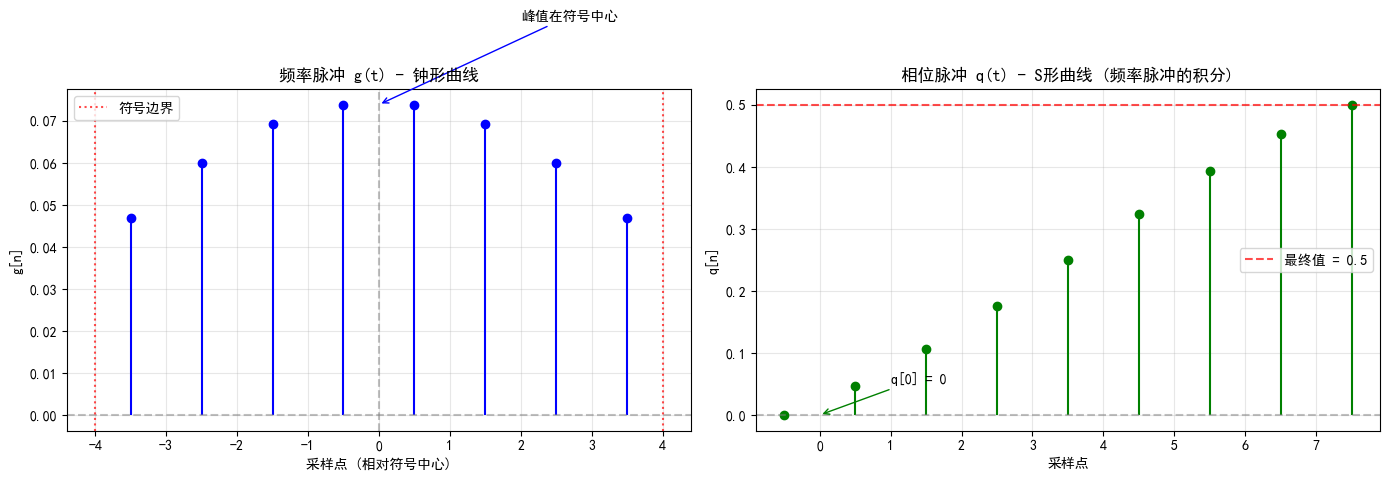

In [6]:
# 可视化频率脉冲
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图: 频率脉冲 g(t)
t_samples = np.arange(len(freq_pulse)) - len(freq_pulse)/2 + 0.5
axes[0].stem(t_samples, freq_pulse, basefmt=' ', linefmt='b-', markerfmt='bo')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)

# 绘制符号边界
axes[0].axvline(-4, color='red', linestyle=':', alpha=0.7, label='符号边界')
axes[0].axvline(4, color='red', linestyle=':', alpha=0.7)

axes[0].set_xlabel('采样点 (相对符号中心)')
axes[0].set_ylabel('g[n]')
axes[0].set_title('频率脉冲 g(t) - 钟形曲线')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 标注
axes[0].annotate('峰值在符号中心', xy=(0, freq_pulse[len(freq_pulse)//2]), 
                xytext=(2, freq_pulse[len(freq_pulse)//2] + 0.02),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=10)

# 右图: 相位脉冲 q(t)
t_phase = np.arange(len(phase_pulse)) - 0.5
axes[1].stem(t_phase, phase_pulse, basefmt=' ', linefmt='g-', markerfmt='go')
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='最终值 = 0.5')

# 标注关键点
axes[1].annotate(f'q[0] = 0', xy=(0, 0), xytext=(1, 0.05),
                arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)
axes[1].annotate(f'q[N] = 0.5', xy=(8, 0.5), xytext=(6, 0.55),
                arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

axes[1].set_xlabel('采样点')
axes[1].set_ylabel('q[n]')
axes[1].set_title('相位脉冲 q(t) - S形曲线 (频率脉冲的积分)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. BT 参数的影响

**BT (Bandwidth-Time product)** 控制高斯滤波器的"宽度"：

- **BT 小**: 脉冲窄，频率变化快，频谱宽
- **BT 大**: 脉冲宽，频率变化慢，频谱窄，但可能有 ISI

**BLE 使用 BT = 0.5**，是频谱效率和抗 ISI 的平衡点。

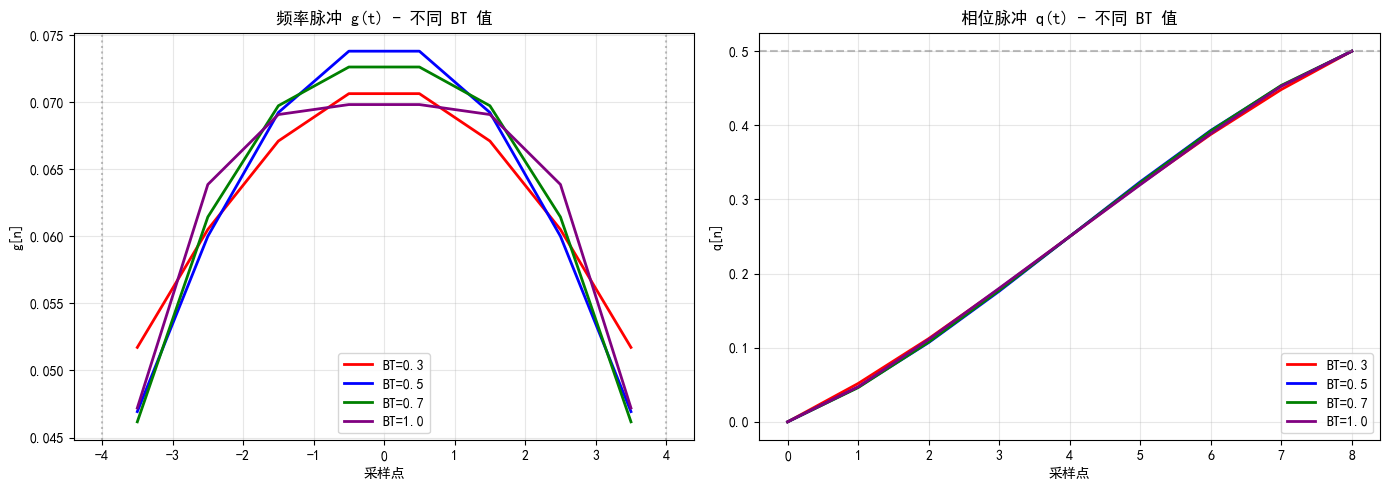

观察:
- BT 越小，频率脉冲越"尖"，变化越快
 BT 越大，频率脉冲越"宽"，变化越平缓
- 所有 BT 值的相位脉冲最终都到达 0.5 (归一化)


In [8]:
# 不同 BT 值的频率脉冲对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bt_values = [0.3, 0.5, 0.7, 1.0]
colors = ['red', 'blue', 'green', 'purple']

for bt, color in zip(bt_values, colors):
    g, q, _, _ = generate_frequency_pulse(bt=bt, sps=8, L=1)
    t = np.arange(len(g)) - len(g)/2 + 0.5
    
    axes[0].plot(t, g, color=color, linewidth=2, label=f'BT={bt}')
    
    t_q = np.arange(len(q))
    axes[1].plot(t_q, q, color=color, linewidth=2, label=f'BT={bt}')

axes[0].axvline(-4, color='gray', linestyle=':', alpha=0.5)
axes[0].axvline(4, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('采样点')
axes[0].set_ylabel('g[n]')
axes[0].set_title('频率脉冲 g(t) - 不同 BT 值')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('采样点')
axes[1].set_ylabel('q[n]')
axes[1].set_title('相位脉冲 q(t) - 不同 BT 值')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("观察:")
print('- BT 越小，频率脉冲越"尖"，变化越快')
print(' BT 越大，频率脉冲越"宽"，变化越平缓')
print("- 所有 BT 值的相位脉冲最终都到达 0.5 (归一化)")

## 6. 脉冲长度 L (Pulse Length) 与 ISI

### Full Response vs Partial Response

| 类型 | L 值 | 特点 |
|------|------|------|
| **Full Response** | L = 1 | 脉冲完全包含在一个符号周期内，无 ISI |
| **Partial Response** | L > 1 | 脉冲扩展到多个符号周期，有 ISI |

**BLE 使用 Full Response (L = 1)**

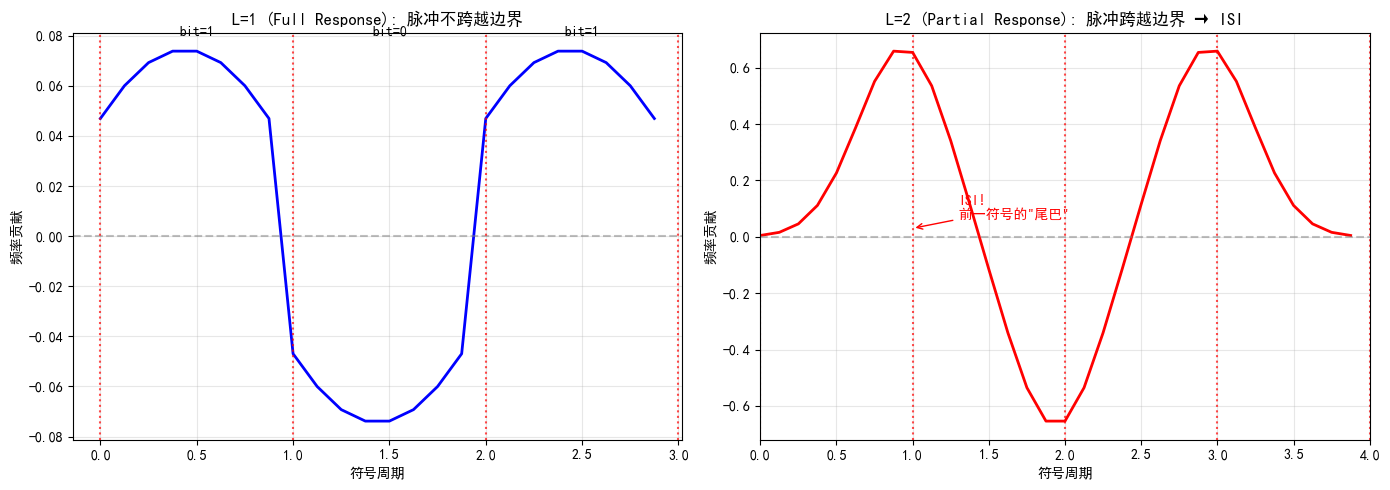

In [9]:
# L=1 vs L=2 对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# L=1 Full Response
g1, q1, _, _ = generate_frequency_pulse(bt=0.5, sps=8, L=1)
t1 = np.arange(len(g1))

# 模拟 3 个连续符号 [1, 0, 1]
symbols = [1, -1, 1]
full_signal = np.zeros(3 * 8)

for i, sym in enumerate(symbols):
    full_signal[i*8:(i+1)*8] = sym * g1

t_full = np.arange(len(full_signal)) / 8
axes[0].plot(t_full, full_signal, 'b-', linewidth=2)
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# 符号边界
for i in range(4):
    axes[0].axvline(i, color='red', linestyle=':', alpha=0.7)

axes[0].set_xlabel('符号周期')
axes[0].set_ylabel('频率贡献')
axes[0].set_title('L=1 (Full Response): 脉冲不跨越边界')
axes[0].grid(True, alpha=0.3)

# 标注
for i, sym in enumerate(symbols):
    bit = 1 if sym > 0 else 0
    axes[0].text(i + 0.5, 0.08, f'bit={bit}', ha='center', fontsize=10)

# L=2 Partial Response (模拟)
# 使用更宽的高斯脉冲模拟 L=2
g2_len = 16  # 跨越 2 个符号周期
t2 = np.linspace(-1, 1, g2_len)
g2 = np.exp(-t2**2 / 0.2)  # 宽高斯
g2 = g2 / np.sum(g2) * 0.5 * 8  # 归一化

# 卷积模拟
partial_signal = np.zeros(4 * 8)  # 多留一个周期
for i, sym in enumerate(symbols):
    start = i * 8
    partial_signal[start:start+g2_len] += sym * g2

t_partial = np.arange(len(partial_signal)) / 8
axes[1].plot(t_partial, partial_signal, 'r-', linewidth=2)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)

# 符号边界
for i in range(5):
    axes[1].axvline(i, color='red', linestyle=':', alpha=0.7)

axes[1].set_xlabel('符号周期')
axes[1].set_ylabel('频率贡献')
axes[1].set_title('L=2 (Partial Response): 脉冲跨越边界 → ISI')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 4)

# 标注 ISI
axes[1].annotate('ISI!\n前一符号的"尾巴"', xy=(1, 0.03), xytext=(1.3, 0.06),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

plt.tight_layout()
plt.show()

## 7. 符号间干扰 (ISI) 详解

### 什么是 ISI？

**符号间干扰 (Inter-Symbol Interference)** 是指一个符号的信号"泄漏"到相邻符号的区域，影响接收端的判决。

### BLE 如何避免 ISI？

使用 **Full Response (L=1)**：强制将脉冲截断在一个符号周期内。

- **代价**: 符号边界处频率可能不连续
- **好处**: 完全没有 ISI，解调器设计简单

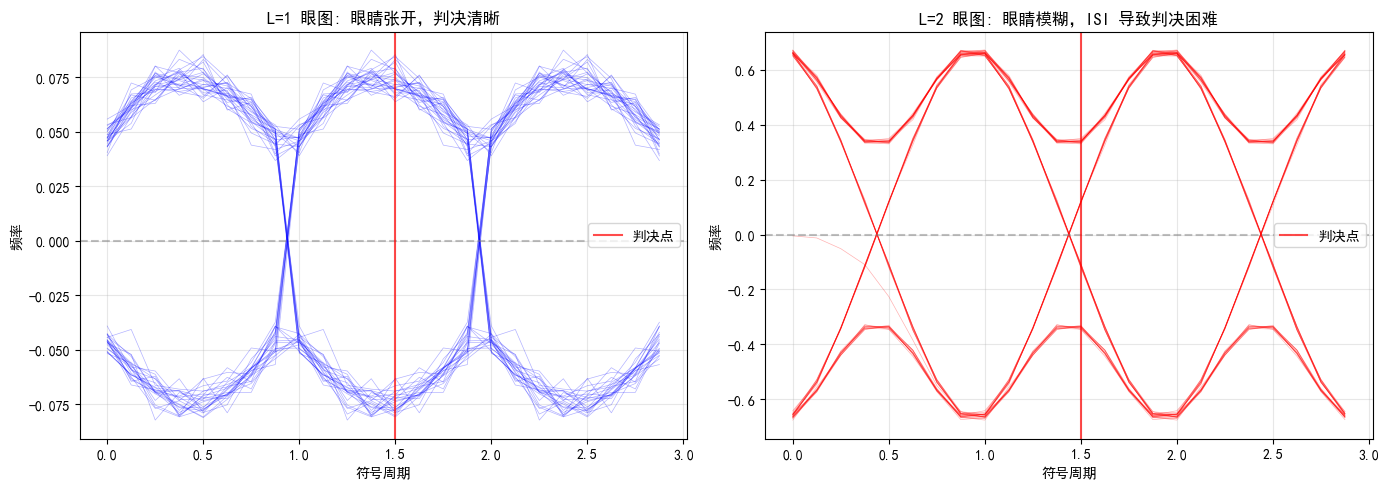

观察:
- L=1: 眼图'眼睛'张开，在判决点容易区分 +1 和 -1
- L=2: 眼图'眼睛'闭合，ISI 使信号模糊，判决困难


In [10]:
# ISI 对接收判决的影响
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 生成眼图数据
np.random.seed(42)
num_symbols = 100
bits = np.random.randint(0, 2, num_symbols)
symbols = 2 * bits - 1

# Full Response (L=1) - 无 ISI
g1, _, _, _ = generate_frequency_pulse(bt=0.5, sps=8, L=1)
signal_l1 = np.zeros(num_symbols * 8)
for i, sym in enumerate(symbols):
    signal_l1[i*8:(i+1)*8] = sym * g1

# 添加少量噪声
signal_l1 += np.random.randn(len(signal_l1)) * 0.005

# 绘制眼图 (叠加多个符号周期)
for i in range(min(50, num_symbols-2)):
    start = i * 8
    segment = signal_l1[start:start+24]  # 3 个符号周期
    t_eye = np.arange(len(segment)) / 8
    axes[0].plot(t_eye, segment, 'b-', alpha=0.3, linewidth=0.5)

axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(1.5, color='red', linestyle='-', alpha=0.7, label='判决点')
axes[0].set_xlabel('符号周期')
axes[0].set_ylabel('频率')
axes[0].set_title('L=1 眼图: 眼睛张开，判决清晰')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Partial Response (L=2) - 有 ISI
g2_len = 16
t2 = np.linspace(-1, 1, g2_len)
g2 = np.exp(-t2**2 / 0.2)
g2 = g2 / np.sum(g2) * 0.5 * 8

signal_l2 = np.zeros((num_symbols + 2) * 8)
for i, sym in enumerate(symbols):
    start = i * 8
    signal_l2[start:start+g2_len] += sym * g2

signal_l2 = signal_l2[:num_symbols * 8]
signal_l2 += np.random.randn(len(signal_l2)) * 0.005

for i in range(min(50, num_symbols-2)):
    start = i * 8
    segment = signal_l2[start:start+24]
    t_eye = np.arange(len(segment)) / 8
    axes[1].plot(t_eye, segment, 'r-', alpha=0.3, linewidth=0.5)

axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(1.5, color='red', linestyle='-', alpha=0.7, label='判决点')
axes[1].set_xlabel('符号周期')
axes[1].set_ylabel('频率')
axes[1].set_title('L=2 眼图: 眼睛模糊，ISI 导致判决困难')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("观察:")
print("- L=1: 眼图'眼睛'张开，在判决点容易区分 +1 和 -1")
print("- L=2: 眼图'眼睛'闭合，ISI 使信号模糊，判决困难")

## 8. 完整调制过程演示

### 调制公式

```
phase[n] = cumulative_phase + h × symbol × phase_pulse[n] × 2π
```

其中:
- h = 0.5 (调制指数)
- symbol = +1 或 -1
- phase_pulse 是 S 形曲线

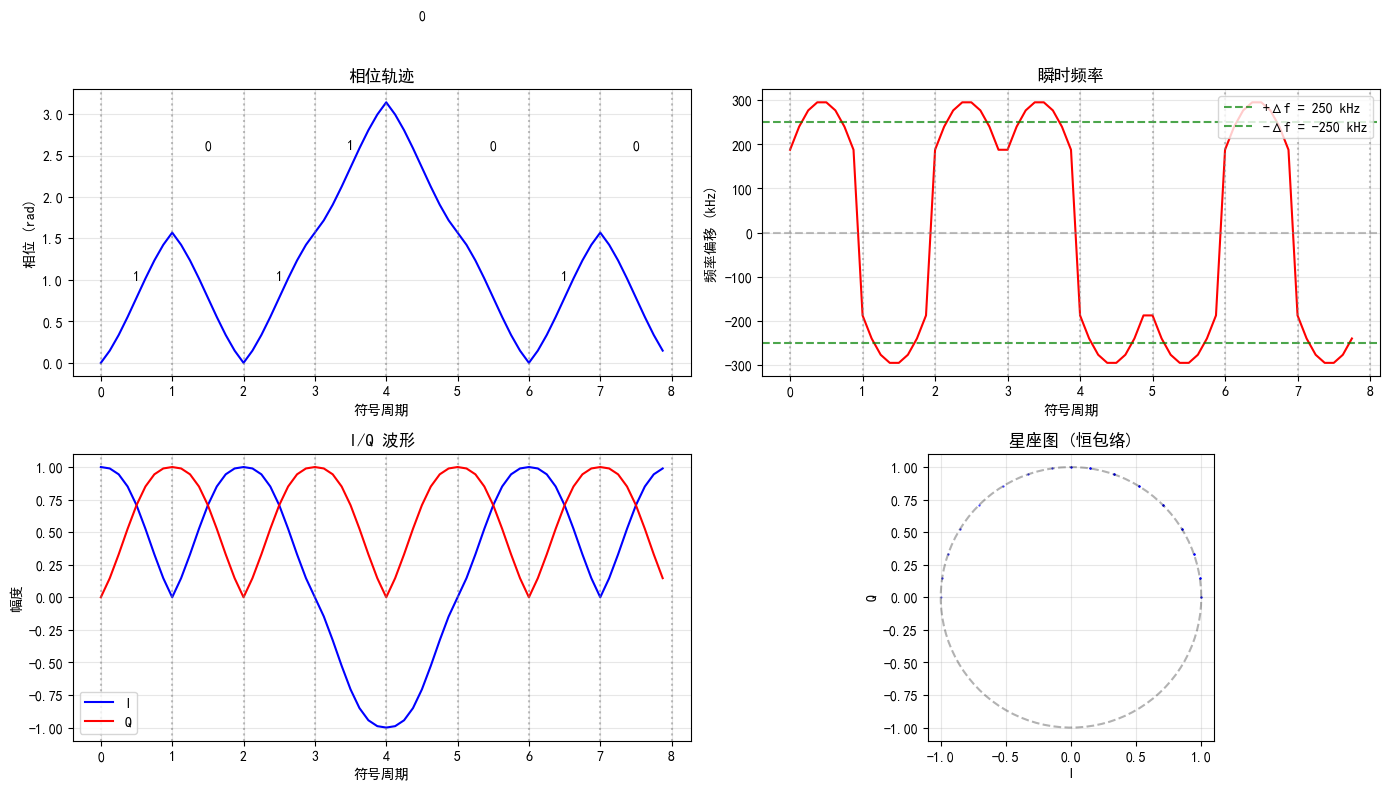

输入比特: [1, 0, 1, 1, 0, 0, 1, 0]
每符号相位变化 = ±π/2 = ±1.5708 rad


In [11]:
# 完整调制演示
def gfsk_modulate(bits, phase_pulse, h=0.5):
    """GFSK 调制"""
    N = len(phase_pulse) - 1  # samples per symbol
    symbols = 2 * np.array(bits) - 1
    nSym = len(symbols)
    
    phase = np.zeros(nSym * N)
    cumulative_phase = 0.0
    
    for i, sym in enumerate(symbols):
        start = i * N
        phase[start:start+N] = cumulative_phase + h * sym * phase_pulse[:N] * 2 * np.pi
        cumulative_phase += h * sym * phase_pulse[N] * 2 * np.pi
    
    iq = np.exp(1j * phase)
    return iq, phase

# 调制一个短序列
bits = [1, 0, 1, 1, 0, 0, 1, 0]
_, phase_pulse, _, _ = generate_frequency_pulse(bt=0.5, sps=8, L=1)

iq, phase = gfsk_modulate(bits, phase_pulse, h=0.5)

# 计算瞬时频率
inst_freq = np.diff(np.unwrap(phase)) / (2 * np.pi) * 8e6 / 1e3  # kHz

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

t_samples = np.arange(len(phase))
t_sym = t_samples / 8

# 1. 相位
axes[0, 0].plot(t_sym, phase, 'b-', linewidth=1.5)
for i in range(len(bits) + 1):
    axes[0, 0].axvline(i, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('符号周期')
axes[0, 0].set_ylabel('相位 (rad)')
axes[0, 0].set_title('相位轨迹')
axes[0, 0].grid(True, alpha=0.3)

# 标注比特
for i, bit in enumerate(bits):
    axes[0, 0].text(i + 0.5, phase[i*8] + 1, str(bit), ha='center', fontsize=10)

# 2. 瞬时频率
axes[0, 1].plot(t_sym[:-1], inst_freq, 'r-', linewidth=1.5)
axes[0, 1].axhline(250, color='green', linestyle='--', alpha=0.7, label='+Δf = 250 kHz')
axes[0, 1].axhline(-250, color='green', linestyle='--', alpha=0.7, label='-Δf = -250 kHz')
axes[0, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
for i in range(len(bits) + 1):
    axes[0, 1].axvline(i, color='gray', linestyle=':', alpha=0.5)
axes[0, 1].set_xlabel('符号周期')
axes[0, 1].set_ylabel('频率偏移 (kHz)')
axes[0, 1].set_title('瞬时频率')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# 3. I/Q 波形
axes[1, 0].plot(t_sym, iq.real, 'b-', linewidth=1.5, label='I')
axes[1, 0].plot(t_sym, iq.imag, 'r-', linewidth=1.5, label='Q')
for i in range(len(bits) + 1):
    axes[1, 0].axvline(i, color='gray', linestyle=':', alpha=0.5)
axes[1, 0].set_xlabel('符号周期')
axes[1, 0].set_ylabel('幅度')
axes[1, 0].set_title('I/Q 波形')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 星座图
axes[1, 1].plot(iq.real, iq.imag, 'b.', markersize=1, alpha=0.5)
# 绘制单位圆
theta = np.linspace(0, 2*np.pi, 100)
axes[1, 1].plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3)
axes[1, 1].set_xlabel('I')
axes[1, 1].set_ylabel('Q')
axes[1, 1].set_title('星座图 (恒包络)')
axes[1, 1].set_aspect('equal')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"输入比特: {bits}")
print(f"每符号相位变化 = ±π/2 = ±{np.pi/2:.4f} rad")

## 9. 关键参数总结

### BLE GFSK 参数

| 参数 | 值 | 说明 |
|------|-----|------|
| BT | 0.5 | 带宽时间积 |
| h | 0.5 | 调制指数 |
| L | 1 | 脉冲长度 (Full Response) |
| 符号率 | 1 MHz (LE 1M) / 2 MHz (LE 2M) | - |

### 相位变化

每个符号的相位变化:
```
Δphase = h × symbol × phase_pulse[N] × 2π
       = 0.5 × (±1) × 0.5 × 2π
       = ±π/2 ≈ ±1.5708 rad
```

### 频率偏移

```
平均频偏 = h × symbol_rate / 2 = 0.5 × 1MHz / 2 = 250 kHz
```

In [ ]:
# 验证 phase_pulse 的值
_, phase_pulse, _, _ = generate_frequency_pulse(bt=0.5, sps=8, L=1)

print("phase_pulse (N+1 = 9 个点):")
print("="*50)
for i, val in enumerate(phase_pulse):
    marker = "← 符号开始" if i == 0 else ("← 符号结束 (用于累积相位)" if i == 8 else "")
    print(f"  phase_pulse[{i}] = {val:.6f}  {marker}")

print("\n记忆要点:")
print("  1. phase_pulse 有 N+1 个点 (不是 N 个)")
print("  2. phase_pulse[0] = 0")
print("  3. phase_pulse[N] = 0.5")
print("  4. 调制时使用 phase_pulse[:N] (前 N 个点)")
print("  5. 累积相位使用 phase_pulse[N] = 0.5")

## 10. 与 BLE Studio 代码的对应

```python
# ble_studio/modulator.py

# 生成相位脉冲 (N+1 个点)
self.phase_pulse = np.concatenate([[0], np.cumsum(g)])  # N+1 个点

# 调制循环
for i in range(nSym):
    sym = symbols[i]
    start = i * N
    
    # 使用前 N 个点
    phase[start:start + N] = cumulative_phase + h * sym * self.phase_pulse[:N] * 2 * np.pi
    
    # 累积相位使用第 N+1 个点 (= 0.5)
    cumulative_phase += h * sym * self.phase_pulse[N] * 2 * np.pi
```